# Bayesian Inference with Stan

This notebook contains examples of Bayesian inference with Stan, using the pyStan interface.

Resources:
http://mc-stan.org/ : Stan's main website, with lots of documentation and examples
http://pystan.readthedocs.io/ : pyStan documentation

8-Schools example from Bayesian Data Analysis, by Andrew Gelman et al., http://andrewgelman.com/2014/01/21/everything-need-know-bayesian-statistics-learned-eight-schools/, and http://astrostatistics.psu.edu/su14/lectures/Daniel-Lee-Stan-2.pdf

Stephen Hoover<br>
Civis Analytics<br>
@StephenActual<br>
7 May 2016

In [1]:
import pickle
import numpy as np
import pandas as pd

import pystan

%matplotlib inline

# Linear Regression

Let's start simple, with linear regression. 

$$ y = \beta x + \epsilon$$
Here, $y$ are the observed outcomes, $x$ are the features we know about each example, $\beta$ are our coefficents, and $\epsilon$ is the noise.

We can fit this with ordinary least squares. To do that, we want to pick $\beta$ such that we minimize
$$ \sum_{i=1}^n (y_i - \beta x_i)^2 $$
We can write down a this linear regression model in Stan code as

In [2]:
stan_model = """
data {
    // Define input data in this block
    int n;  // Number of samples
    int m;  // Number of features
    matrix[n, m] features;
    vector[n] y;  // outcome
}
transformed data {
    // Modify / transform input data.
    // This block runs once.
}
parameters {
    // These are random parameters which we
    // want to estimate
    vector[m] beta;  // Coefficients
    real<lower=0> epsilon;  // Uncertainty / unexplained variance
}
transformed parameters {
    // Create quantities derived from the parameters.
    // Runs on every evaluation of log-prob
}
model {
    // Define your model here!
    y ~ normal(features * beta, epsilon);
    
    // Equivalent to:
    // increment_log_prob(normal_log(y, features * beta, epsilon));
}
generated quantities {
    // Can use to simulate / predict using parameters
    // Runs once per MCMC step after warmup
}
"""

In [3]:
# Generate some data for us to fit
rng = np.random.RandomState(42)
n_samples = 10
n_feat = 4

feat = rng.normal(0, 1, size=(n_samples, n_feat))
tgt = feat @ np.array([-1, 0.4, 0, 0]) + rng.normal(scale=0.2, size=n_samples)

In [4]:
lin_reg = pystan.model.StanModel(model_code=stan_model,
                                 model_name='linear_regression')

In [5]:
lin_fit = lin_reg.sampling(data={'n': n_samples, 
                                 'm': n_feat, 
                                 'features': feat, 
                                 'y': tgt}, 
                           iter=1000, chains=4, 
                           warmup=500, n_jobs=-1,
                           seed=42)

In [6]:
lin_fit

Inference for Stan model: linear_regression_087f0c0e4eef3ff0be6e63bbe468afe1.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]  -0.99  5.4e-3   0.11   -1.2  -1.05  -0.99  -0.92  -0.75    449    1.0
beta[1]   0.43  4.1e-3   0.08   0.27   0.38   0.43   0.47   0.59    400   1.01
beta[2]   0.07  4.0e-3   0.08  -0.09   0.03   0.07   0.11   0.22    355    1.0
beta[3]   0.08  3.0e-3   0.06  -0.07   0.04   0.08   0.11    0.2    455    1.0
epsilon    0.2  5.3e-3   0.08   0.11   0.14   0.18   0.23   0.42    245   1.02
lp__     10.66    0.15    2.3   4.63   9.61  11.16  12.35  13.59    241   1.02

Samples were drawn using NUTS(diag_e) at Sat May  7 13:47:55 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [7]:
chains = lin_fit.extract()

In [8]:
chains

OrderedDict([('beta',
              array([[-1.01763661,  0.37649818,  0.10570001,  0.05404354],
                     [-0.93332508,  0.50234876,  0.17387378, -0.09616874],
                     [-0.89627442,  0.47404553,  0.01599869,  0.1143778 ],
                     ..., 
                     [-0.86882841,  0.36307688,  0.02157189,  0.06358885],
                     [-0.96600794,  0.51663891,  0.05793773,  0.08761251],
                     [-0.99316095,  0.41921682,  0.01724642,  0.0535017 ]])),
             ('epsilon',
              array([ 0.08935834,  0.33816026,  0.18961911, ...,  0.20131365,
                      0.17700009,  0.11271441])),
             ('lp__',
              array([ 11.35349354,   6.57292638,  12.33864629, ...,  10.52931093,
                      12.25936065,  12.17528791]))])

In [9]:
chains['beta'].shape

(2000, 4)

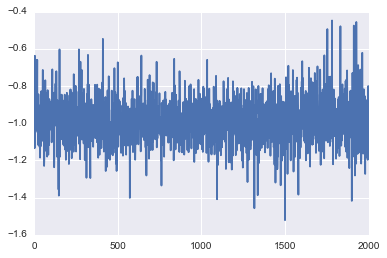

In [10]:
plt.plot(chains['beta'][:,0])

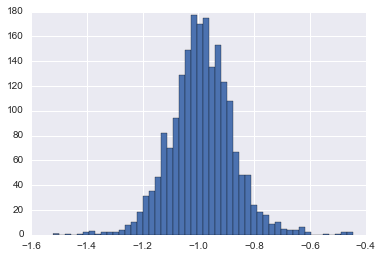

In [11]:
histout = plt.hist(chains['beta'][:,0], bins=50)

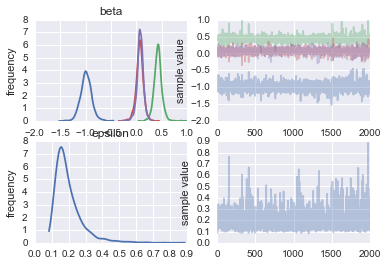

In [12]:
p = lin_fit.plot()

## Interlude: Caching models

It can take a long(ish) time to compile these models, so you often want to save them for later. Good news: the models can be pickled!

In [13]:
with open("/Users/shoover/linear_regression_stan.pkl", 'wb') as fout:
    pickle.dump(lin_reg, fout)
    
# If you want to get fancy, you can write a 
# function to do this automatically.
# This version adapted from the pyStan docs.
import os
import pystan
import pickle
from hashlib import md5

def stan_cache(model_code, model_name=None, 
               cache_dir='/Users/shoover/stan_cache'):
    """Creates or retrieves a StanModel"""
    code_hash = md5((model_code + pystan.__version__)
                    .encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = 'cached-model-{}.pkl'.format(code_hash)
    else:
        cache_fn = 'cached-{}-{}.pkl'.format(model_name, code_hash)
    cache_fn = os.path.join(cache_dir, cache_fn)

    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm

# LASSO Regression

We can also get fancier. In LASSO regression, we regularize the model by adding an additional penalty term to our ordinary least squares model:
$$ \sum_{i=1}^n (y_i - \beta x_i)^2  + \lambda \sum_{j=1}^m |\beta_j|$$

You write this in Stan by realizing that it's a prior on your coefficents:

In [14]:
stan_model_lasso = """
data {
    int n;  // Number of samples
    int m;  // Number of features
    matrix[n, m] features;
    vector[n] y;  // Outcome
    real<lower=0> lambda;  // Regularization strength
}
parameters {
    vector[m] beta;  // Coefficients
    real<lower=0> epsilon;  // Uncertainty / unexplained variance
}
model {
    beta ~ double_exponential(0, 1 / lambda);  // Laplace prior
    y ~ normal(features * beta, epsilon);
}
"""

In [15]:
lasso_reg = stan_cache(model_code=stan_model_lasso,
                       model_name='lasso_regression')

Using cached StanModel


In [16]:
lasso_fit = lasso_reg.sampling(
    data={'n': n_samples, 'm': n_feat, 
          'features': feat, 'y': tgt, 'lambda': 10},
    iter=1000, seed=42)

In [17]:
lasso_fit

Inference for Stan model: anon_model_453ed1561ef59806d76edb8b044246f9.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]  -0.75    0.03    0.3  -1.08  -0.95  -0.86  -0.66 2.0e-3    128   1.03
beta[1]   0.36    0.01   0.14-8.1e-3   0.31   0.39   0.45   0.57    153   1.02
beta[2]   0.04  3.6e-3   0.07  -0.11-2.3e-3   0.04   0.08   0.18    388   1.01
beta[3]   0.06  3.6e-3   0.07  -0.08   0.02   0.06    0.1   0.19    362    1.0
epsilon   0.33    0.03   0.27   0.11   0.17   0.22   0.37   1.11    117   1.04
lp__     -5.02    0.19   2.32 -10.12  -6.49  -4.64  -3.19  -1.73    142   1.03

Samples were drawn using NUTS(diag_e) at Sat May  7 13:52:40 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

# 8 Schools: A Multi-level model

Let's look at the "8 schools" problem. This example is originally from Rubin 1981, and can be found in Bayesian Data Analysis (Gelman et al.). These are data on the effectiveness of a class designed to prepare students for the SAT. Each row represents all of the students in one school. In each school, Rubin measured the average change in SAT scores, as well as calculating a measurement uncertainty.

In [18]:
schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}
schools_df = (pd.DataFrame(schools_dat, columns=['y', 'sigma'])
              .rename(columns={'y': 'Treatment Effect', 
                               'sigma': 'Uncertainty'}))
schools_df.index.name = 'School ID'
print(schools_df)

           Treatment Effect  Uncertainty
School ID                               
0                        28           15
1                         8           10
2                        -3           16
3                         7           11
4                        -1            9
5                         1           11
6                        18           10
7                        12           18


### School-by school effects

What can we say about the effectiveness of the training? You might say that the measured effect is our best estimate of how well the class in each school does -- after all, we have a measurement and an uncertainty.

In [19]:
# Assume each school is completely independent
no_pooling = """
data {
    int<lower=0> J; // # schools
    real y[J]; // estimated treatment
    real<lower=0> sigma[J]; // std err of effect
}
parameters {
    real theta[J]; // school effect
}
model {
    y ~ normal(theta, sigma);
}
"""

In [20]:
nopool_model = stan_cache(model_code=no_pooling, 
                          model_name='no_pooling')

Using cached StanModel


In [21]:
nopool_fit = nopool_model.sampling(data=schools_dat)

In [22]:
nopool_fit

Inference for Stan model: anon_model_fac03134a8935fb2cffe1e3eb2e31136.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0]  28.06    0.42  15.17  -2.08  17.77  27.83  38.14  58.85   1321    1.0
theta[1]   8.02    0.27   9.88 -10.72   1.39   7.77  14.75   27.7   1334    1.0
theta[2]  -3.23    0.44  16.23 -36.22 -14.03  -3.23   7.53  28.35   1334    1.0
theta[3]   7.17    0.31  11.07 -14.71  -0.18   6.99  14.57   28.8   1287    1.0
theta[4]  -1.14    0.26   9.28 -19.87  -7.51  -1.08    5.2  16.92   1299    1.0
theta[5]   1.05    0.31  11.07  -20.4  -6.61   1.23   8.71  22.59   1290    1.0
theta[6]  18.09    0.28   9.96  -1.31  11.23  18.23   24.8  37.82   1305    1.0
theta[7]  12.46     0.5   18.3 -22.54   0.26  11.95  24.79   49.2   1319    1.0
lp__      -4.07    0.07   2.04  -9.17  -5.16  -3.75   -2.6  -1.14    958    1.0

Samples we

### Pooling

But that doesn't seem quite right. Each school was using the same training class, so maybe we should say that there's just one "effectiveness of training" parameter, and the result of training in each school is a noisy measurement of this one number.

In [23]:
pooling = """
data {
    int<lower=0> J; // # schools
    real y[J]; // estimated treatment
    real<lower=0> sigma[J]; // std err of effect
}
parameters {
    real theta; // pooled school effect
}
model {
    y ~ normal(theta, sigma);
}
"""

In [24]:
pool_model = stan_cache(model_code=pooling,
                        model_name='pooling')

Using cached StanModel


In [25]:
pool_fit = pool_model.sampling(data=schools_dat)

In [26]:
pool_fit

Inference for Stan model: anon_model_78b569a62c9d87b3382fb8822816ffa7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta    7.7    0.15   3.93   0.11   5.03   7.68  10.35  15.59    717    1.0
lp__   -2.82    0.02   0.67  -4.69  -2.96  -2.57   -2.4  -2.35    863    1.0

Samples were drawn using NUTS(diag_e) at Sat May  7 13:54:52 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

### Partial Pooling

Our data are consistent with all the training programs creating a treatment effect of 8 points. But that doesn't seem right either. There's different teachers in each school, teaching the classes in different ways. What if there's some average effect of the program, but different schools do a better or worse job of teaching it.

In [27]:
part_pool = """
data {
    int<lower=0> J; // # schools
    real y[J]; // estimated treatment
    real<lower=0> sigma[J]; // std err of effect
    real<lower=0> tau;  // Width of school effect distribution
}
parameters {
    real theta[J]; // school effect
    real mu; // Average treatment effect
}
model {
    theta ~ normal(mu, tau);
    y ~ normal(theta, sigma);
}
"""

In [28]:
part_model = stan_cache(model_code=part_pool, 
                        model_name='partial_pooling')

Using cached StanModel


In [29]:
part_fit = part_model.sampling(data={**schools_dat, 'tau': 25})

In [30]:
part_fit

Inference for Stan model: anon_model_54826fd87a6d262851a3832021fc15d0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0]  22.73    0.37  13.26  -3.56  13.74  22.74  31.59  49.47   1280    1.0
theta[1]   8.03    0.26   9.35 -10.48   1.58   7.92  14.25  26.87   1296    1.0
theta[2]   0.56    0.39  13.97 -26.49  -9.03   0.57  10.23  28.02   1272    1.0
theta[3]   7.14    0.28  10.06 -12.26   0.39   6.88   13.8  27.28   1309    1.0
theta[4]    0.2    0.25   8.74 -16.96   -5.9    0.3   6.01  17.26   1261    1.0
theta[5]   2.05    0.29  10.46 -18.58   -4.9   1.99   9.13  22.04   1285    1.0
theta[6]  16.75    0.27   9.62  -2.46  10.33  16.68  23.33  35.36   1265    1.0
theta[7]  11.32    0.42  15.18 -18.53   0.85  11.03  21.75  40.65   1305    1.0
mu         9.01    0.28   9.92 -10.63   2.25    9.1  15.81  28.13   1235    1.0
lp__      -

In [31]:
# Compare to input data
print(schools_df)

           Treatment Effect  Uncertainty
School ID                               
0                        28           15
1                         8           10
2                        -3           16
3                         7           11
4                        -1            9
5                         1           11
6                        18           10
7                        12           18


### Hierarchical Model

But we can still do one better. I picked that "tau" pretty arbitrarily. What if I don't know how much the schools can vary from the overall class treatment effect? We can estimate that from the data too!

In [33]:
schools_hier = """
data {
    int<lower=0> J; // # schools
    real y[J]; // estimated treatment
    real<lower=0> sigma[J]; // std err of effect
}
parameters {
    real theta[J]; // school effect
    real mu; // mean for schools
    real<lower=0> tau; // variance between schools
}
model {
    theta ~ normal(mu, tau);
    y ~ normal(theta, sigma);
}
"""

In [34]:
hier_model = stan_cache(model_code=schools_hier, 
                        model_name='hierarchical_model')

Using cached StanModel


In [35]:
hier_fit = hier_model.sampling(data=schools_dat)

In [36]:
hier_fit

Inference for Stan model: anon_model_bb61d0eae3d6ef378c04e5c9a4c3d37a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0]  12.24    0.36   8.45  -1.52   6.87  11.45   15.7  33.36    542    1.0
theta[1]   8.54    0.25   6.38  -4.79   4.63   8.64  12.79   20.9    631    1.0
theta[2]    6.7    0.37   7.96 -12.18    2.7   7.29  11.92  20.47    465    1.0
theta[3]   8.03    0.28   6.36  -5.53   4.25   8.13  12.14  20.26    517    1.0
theta[4]   5.36    0.41   6.56  -9.19   1.49   6.02   9.91  16.01    254   1.01
theta[5]   6.71    0.33   6.75  -8.97   3.05   7.31  11.37  18.67    415    1.0
theta[6]   11.5    0.29   6.72  -0.17   7.18  10.91  15.18  26.49    547    1.0
theta[7]   9.08    0.29   8.08  -7.23   4.57   8.99   13.6  26.17    803    1.0
mu          8.5    0.26   5.19  -2.17   5.42    8.5  11.96  18.71    384    1.0
tau        

In [37]:
schools_df

,Treatment Effect,Uncertainty
School ID,,
0,28,15
1,8,10
2,-3,16
3,7,11
4,-1,9
5,1,11
6,18,10
7,12,18


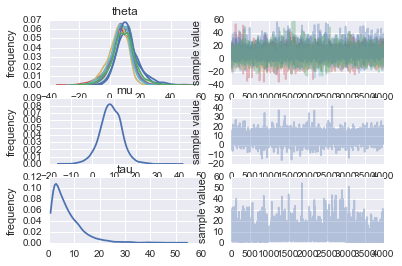

In [38]:
pp = hier_fit.plot()